In [3]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML


In [4]:
manualSeed = random.randint(1, 10000) 
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  6197


In [5]:
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cup')
    
print(DEVICE)

cuda


In [16]:
# 데이터셋의 경로
dataroot = "E:/Study_file/visual_studio_code/vscode_pytorch/project_GAN/celeba/"

batch_size = 128  # 배치size
EPOCHS = 5

# latent vector는 100으로 설정

# transform resize- 모든 이미지를 64로 변환
image_size = 64
workers = 2  # dataloader에서 사용할 쓰레드 수
lr = 0.0001
ngpu = 1

In [7]:
transform_setting = transforms.Compose([transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

dataset = dset.ImageFolder(root=dataroot, transform=transform_setting)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

In [8]:
for (inputs, labels) in (dataloader):
    print("input shape : ", inputs.size())
    print("labels shape : ", labels.size())
    break

input shape :  torch.Size([128, 3, 64, 64])
labels shape :  torch.Size([128])


In [9]:
# dataloader에 저장된 이미지들 중에서 1 배치의 idx번째 이미지 출력
def display_images(dataloader, batch_size=128, batch_idx=0, img_idx=0):
    for idx,(images, labels) in enumerate(dataloader):
        if idx == batch_idx:
            images = images.numpy().transpose((0, 2, 3, 1)) # Transpose to (batch_size, height, width, channels)
            plt.imshow(images[img_idx])
            plt.axis('off')
            plt.show()
            return

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


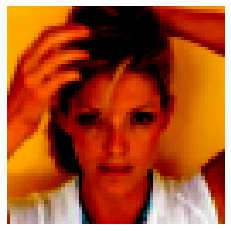

In [10]:
# 1번째 배치의 10번째 이미지 출력
display_images(dataloader,batch_idx=1, img_idx=10)

In [11]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [12]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.conv1 = nn.ConvTranspose2d(100, 64 * 8, 4, 1, 0, bias=False)
        self.bn1 = nn.BatchNorm2d(64 * 8)
        self.relu1 = nn.ReLU(True)
        self.conv2 = nn.ConvTranspose2d(64 * 8, 64 * 4, 4, 2, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(64 * 4)
        self.relu2 = nn.ReLU(True)
        self.conv3 = nn.ConvTranspose2d( 64 * 4, 64 * 2, 4, 2, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(64 * 2)
        self.relu3 = nn.ReLU(True)
        self.conv4 = nn.ConvTranspose2d( 64 * 2, 64, 4, 2, 1, bias=False)
        self.bn4 = nn.BatchNorm2d(64)
        self.relu4 = nn.ReLU(True)
        self.conv5 = nn.ConvTranspose2d( 64, 3, 4, 2, 1, bias=False)
        self.tanh = nn.Tanh()

    def forward(self, input):
        x = self.conv1(input)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu4(x)
        x = self.conv5(x)
        return self.tanh(x)

In [13]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.conv1 = nn.Conv2d(3, 64, 4, 2, 1, bias=False)
        self.relu1 = nn.LeakyReLU(0.2, inplace=True)
        self.conv2 = nn.Conv2d(64, 64 * 2, 4, 2, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(64 * 2)
        self.relu2 = nn.LeakyReLU(0.2, inplace=True)
        self.conv3 = nn.Conv2d(64 * 2, 64 * 4, 4, 2, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(64 * 4)
        self.relu3 = nn.LeakyReLU(0.2, inplace=True)
        self.conv4 = nn.Conv2d(64 * 4, 64 * 8, 4, 2, 1, bias=False)
        self.bn4 = nn.BatchNorm2d(64 * 8)
        self.relu4 = nn.LeakyReLU(0.2, inplace=True)
        self.conv5 = nn.Conv2d(64 * 8, 1, 4, 1, 0, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input):
        x = self.conv1(input)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu4(x)
        x = self.conv5(x)
        x = self.sigmoid(x)
        return x

In [14]:
Generator_model = Generator(ngpu).to(DEVICE)
Generator_model.apply(weights_init)
Discriminator_model = Discriminator(ngpu).to(DEVICE)
Discriminator_model.apply(weights_init)

criterion = nn.BCELoss()

# 생성자의 학습상태를 확인할 latent vector
fixed_noise = torch.randn(64, 100, 1, 1, device=DEVICE)

# true/false 라벨
real_label = 1.
fake_label = 0.

optimizerD = optim.Adam(Discriminator_model.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerG = optim.Adam(Generator_model.parameters(), lr=lr, betas=(0.5, 0.999))

In [17]:
# loss 값을 저장할 리스트
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
for epoch in range(EPOCHS):
    for i, (data,target) in enumerate(dataloader):
        # (1) Discriminator_model 업데이트 : log(D(x)) + log(1 - D(G(z)))를 최대화 합니다
        Discriminator_model.zero_grad()
    
        # 데이터 셋에 target값이 설정되어 있지 않기 때문에 label을 만들어줌
        label = torch.full((data.size(0),), real_label, dtype=torch.float, device=DEVICE)
       
        output = Discriminator_model(data.to(DEVICE)).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        # latent vector100으로 노이즈 생성. Generator_model, 노이즈를 이용해 가짜 이미지를 생성.  
        noise = torch.randn(data.size(0), 100, 1, 1, device=DEVICE)

        fake = Generator_model(noise)
        label.fill_(fake_label)
        # discriminator로 가짜 이미지의 loss 구하기
        output = Discriminator_model(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        
        # 가짜 이미지와 진짜 이미지 모두에서 구한 손실값들을 더합니다
        errD = errD_real + errD_fake
        
        optimizerD.step()

        # (2) Generator_model 업데이트 : log(D(G(z)))를 최대화
        Generator_model.zero_grad()
        label.fill_(real_label)  # 생성자의 손실값을 구하기 위해 진짜 라벨을 이용할 겁니다
        
        output = Discriminator_model(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        
        optimizerG.step()

        if i % 100 == 0:
            print('[%d/%d][%d/%d]  Loss_D: %.4f  Loss_G: %.4f  D(x): %.4f  D(G(z)): %.4f / %.4f'
                  % (epoch, EPOCHS, i, len(dataloader), errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
            
            # loss 값의 변화를 보기 위해, loss 값들을 저장해둡니다
            G_losses.append(errG.item())
            D_losses.append(errD.item())

        
        # fixed_noise를 통과시킨 G의 출력값을 저장해둡니다
        if (iters % 500 == 0) or ((epoch == EPOCHS-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = Generator_model(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
    

        iters += 1

Starting Training Loop...
[0/5][0/1583]  Loss_D: 0.1846  Loss_G: 5.0250  D(x): 0.8994  D(G(z)): 0.0311 / 0.0103
[0/5][100/1583]  Loss_D: 0.0673  Loss_G: 8.9398  D(x): 0.9803  D(G(z)): 0.0325 / 0.0002
[0/5][200/1583]  Loss_D: 0.0013  Loss_G: 33.5942  D(x): 0.9987  D(G(z)): 0.0000 / 0.0000
[0/5][300/1583]  Loss_D: 0.1645  Loss_G: 8.8076  D(x): 0.9883  D(G(z)): 0.1269 / 0.0003
[0/5][400/1583]  Loss_D: 0.4307  Loss_G: 10.3470  D(x): 0.7548  D(G(z)): 0.0004 / 0.0002
[0/5][500/1583]  Loss_D: 0.5588  Loss_G: 2.4678  D(x): 0.7148  D(G(z)): 0.0443 / 0.1228
[0/5][600/1583]  Loss_D: 0.3876  Loss_G: 3.5390  D(x): 0.8005  D(G(z)): 0.0791 / 0.0502
[0/5][700/1583]  Loss_D: 0.6223  Loss_G: 8.5336  D(x): 0.9380  D(G(z)): 0.3484 / 0.0004
[0/5][800/1583]  Loss_D: 0.4815  Loss_G: 5.3412  D(x): 0.8340  D(G(z)): 0.1774 / 0.0070
[0/5][900/1583]  Loss_D: 0.2968  Loss_G: 4.9476  D(x): 0.9131  D(G(z)): 0.1515 / 0.0143
[0/5][1000/1583]  Loss_D: 0.2198  Loss_G: 7.2229  D(x): 0.8518  D(G(z)): 0.0053 / 0.0021
[0/5]

In [69]:
# G,D 모델 저장하고 불러오는 코드 구현
torch.save({'generator_state_dict': Generator_model.state_dict(),
            'discriminator_state_dict': Discriminator_model.state_dict()}, 'DCGAN_model_train_5epoch.pt')

print(Generator_model.state_dict())

OrderedDict([('conv1.weight', tensor([[[[-1.6629e-02,  1.2382e-02,  1.7842e-02,  1.0374e-02],
          [-1.9086e-03,  9.4601e-03, -2.6764e-03, -2.6337e-02],
          [ 3.1480e-02,  1.0113e-02, -4.1867e-03, -1.5097e-02],
          [-2.7411e-02, -8.6734e-04,  8.3408e-03, -1.1010e-02]],

         [[ 4.4157e-02,  3.3040e-02,  4.4926e-02,  4.1536e-02],
          [ 2.5436e-02, -2.6068e-02,  2.2682e-02,  1.9199e-02],
          [ 3.6317e-02, -1.2950e-02,  8.0338e-03,  6.0356e-02],
          [ 3.6168e-02,  5.5982e-02,  5.6051e-02,  4.1684e-02]],

         [[ 1.7614e-03, -3.6351e-02, -4.7954e-02, -5.6016e-03],
          [ 1.2643e-02,  1.9309e-02,  1.9475e-02, -4.4799e-02],
          [-1.6303e-03,  1.7917e-02,  1.3754e-02,  1.7834e-02],
          [-2.6324e-02,  5.7456e-02,  2.3458e-02, -2.9941e-02]],

         ...,

         [[ 5.0520e-02,  2.7551e-02, -1.9635e-02,  1.7573e-03],
          [ 1.6503e-02,  2.0603e-03,  3.4802e-02,  6.9268e-03],
          [-9.4734e-03,  7.0245e-03,  9.5200e-03, -1.

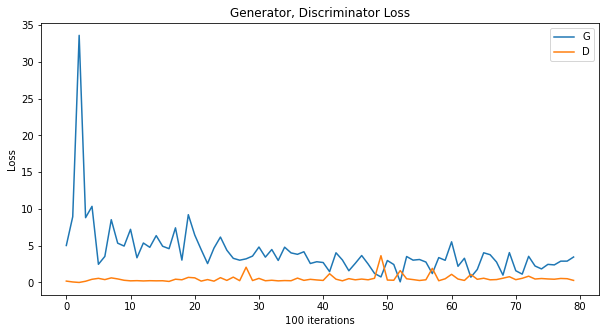

In [70]:
plt.figure(figsize=(10,5))
plt.title("Generator, Discriminator Loss")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("100 iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

torch.Size([3, 530, 530])


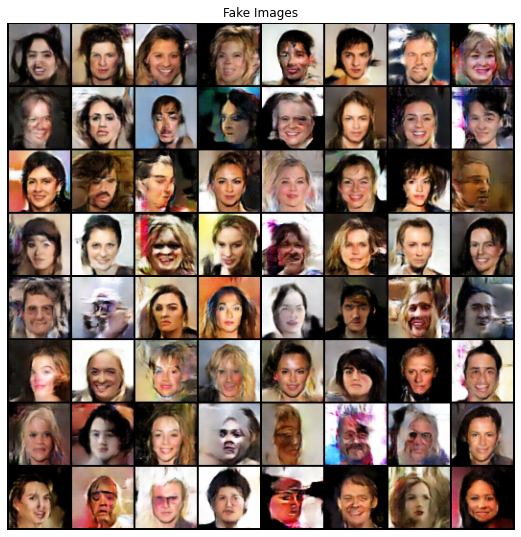

In [111]:
print(img_list[-1].size())

# 마지막 epoch에서 생성된 이미지 출력
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

In [116]:
# 저장된 generator_state를 불러와서 새로운 이미지를 생성해 보았다.
noise = torch.randn(64, 100, 1, 1, device=DEVICE)

load_trained = torch.load("DCGAN_model_train_5epoch.pt")

gmodel = Generator(ngpu).to(DEVICE)
gmodel.load_state_dict(load_trained['generator_state_dict'])

<All keys matched successfully>

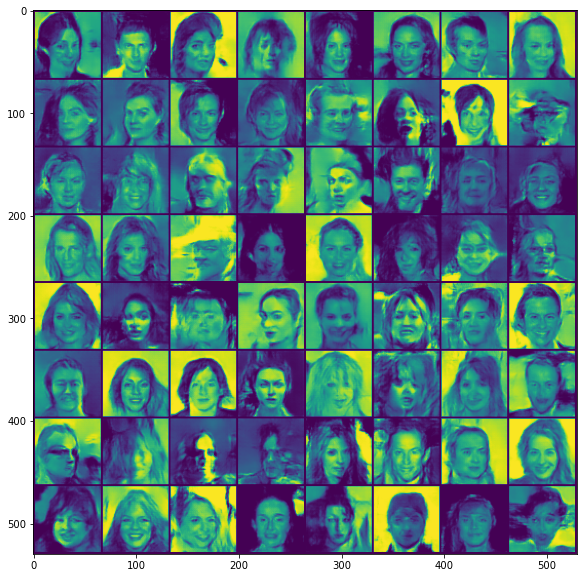

In [117]:
fake_image = gmodel(noise)
fake_image = vutils.make_grid(fake_image, padding=2, normalize=True)
img = transforms.ToPILImage()(fake_image[1].to(DEVICE))
plt.figure(figsize=(20,10))
plt.imshow(img)
plt.show()


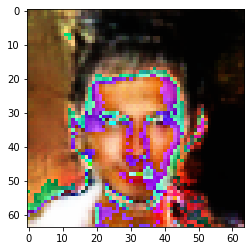

In [118]:
fake_image = gmodel(noise)
img = transforms.ToPILImage()(fake_image[1].to(DEVICE))

plt.imshow(img)
plt.show()